<a href="https://colab.research.google.com/github/m-zaniolo/CEE690-ESAA/blob/main/Lab_5_Direct_Policy_Search_solutions2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 – Direct Policy Search for Lake Operations
This notebook solves a simplified lake–reservoir operation problem with **direct policy search (DPS)**.
You will start from a standard operating policy, evaluate its performance, and then **optimize the policy parameters** across multiple objectives.
You will then repeat the 4‑objective optimization using a **radial basis function (RBF)** policy.



## Problem definition

We simulate a reservoir with daily time steps over a multi‑year inflow record. Storage evolves by mass balance:

- Inflow is exogenous.
- Releases are chosen by a policy as a function of the current storage.
- Evaporation losses depend on a seasonal evaporation time series and an approximate storage–surface relationship.
- Releases are limited by a storage‑dependent physical capacity.

We evaluate each policy on the same four objectives:

1. **Flood days:** number of days the lake level exceeds the maximum safe level.
2. **Water deficit:** mean squared deficit relative to a fixed demand.
3. **Hydropower:** negative mean annual hydropower production.
4. **Level oscillation:** mean annual range of lake level.

All objectives are formulated as **minimization**.
Hydropower is multiplied by −1 so that “more power” corresponds to a smaller objective value.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (10, 4)

# Data URL
url = "https://raw.githubusercontent.com/m-zaniolo/CEE690-ESAA/main/data/"

# Daily inflow [m3/s]
inflow = np.loadtxt(url + "inflow.txt", delimiter="\t")

# Cyclostationary net evaporation [mm/day] (365 values)
evap = np.loadtxt(url + "netevap_Gibe1.txt", delimiter=" ")

# Build a matching date index (leap days removed)
date_range = pd.date_range(start="2001-01-01", end="2015-12-31", freq="D")
date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]

assert len(inflow) == len(date_range), "Inflow length must match date index."
H = len(inflow)               # simulation horizon in days
Ny = H / 365                  # number of years (should be an integer)
print("H (days):", H, " | Ny (years):", Ny)

H (days): 5475  | Ny (years): 15.0


## Model parameters and unit conventions

Key quantities:
- `S`: maximum storage capacity [m³]
- `D`: constant demand [m³/day]
- `max_release`: channel capacity at full storage [m³/day]


In [2]:
# lake Parameters
sim_step = 60 * 60 * 24  # seconds per day
S = 1.47e10 # [m3]

# Demand and max release are specified in [m3/s].
D = 450         # [m3/s]
max_release = 1200  # [m3/s]

# Simple geometry relationships used in this course
stor_to_surface = 0.0142  # converts storage [m3] to surface area proxy [m2/m3]

def level_from_storage(s):
    """Storage [m3] -> lake level [m]."""
    return 0.0521 * (s ** 0.3589)

# Flood threshold is the level at max storage
l_threshold = level_from_storage(S)
print("Flood level threshold [m]:", l_threshold)


Flood level threshold [m]: 232.21374082130072


## Standard operating policy: piecewise linear release rule

We start from a standard operating policy where the *desired* release `u(t)` is a piecewise linear function of current storage `s(t)`:

- Line 1: `L1 = θ0 * s`
- Line 2: `L2 = θ1` (a constant release target, optimized)
- Line 3: `L3 = θ2 + θ3 * s`

Then:
- `u(t) = max( min(L1, L2), L3 )`

Finally, the *actual* release `r(t+1)` is constrained by a storage‑dependent capacity:
- `r(t+1) = clip( u(t), 0, s(t) * max_release / S )`


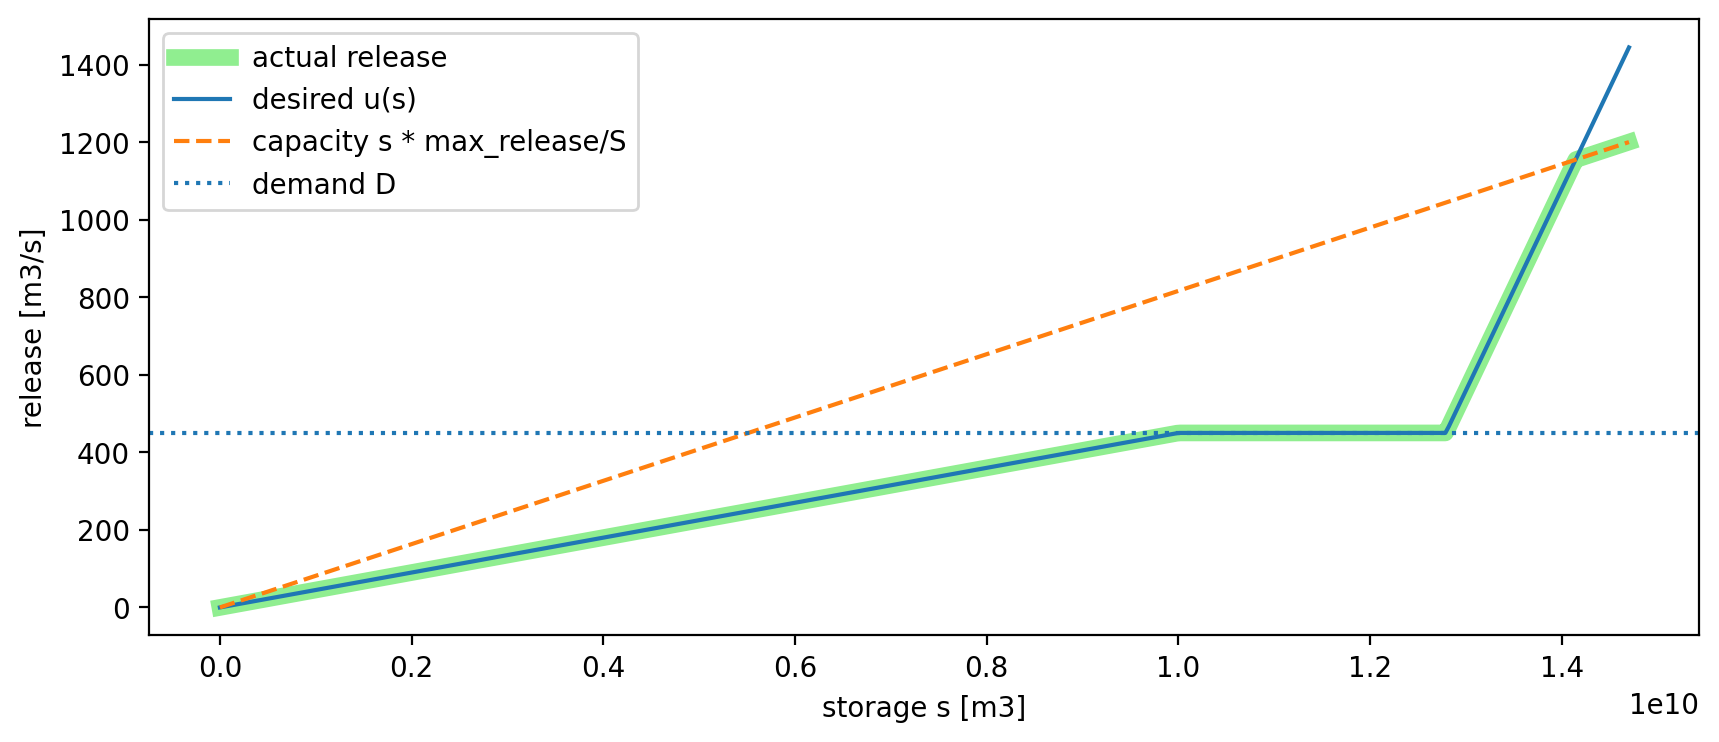

In [3]:
def policy_pwlin(s, theta):
    """Piecewise linear policy.

    Inputs:
      s: storage [m3]
      theta: [θ0, θ1, θ2, θ3]
    Output:
      u: desired release [m3/s]
    """
    L1 = theta[0] * s
    L2 = theta[1]
    L3 = theta[2] + theta[3] * s
    return max(min(L1, L2), L3)

# Example policy parameters (for plotting only)
# theta = [θ0, θ1, θ2, θ3] where θ1 is now an optimized constant target
theta0 = np.array([0.000000045, D, -6200.0, 0.00000052])

# Visualize the policy shape over storage
s_values = np.linspace(0, S, 400)
u_values = np.array([policy_pwlin(s, theta0) for s in s_values])
cap_values = s_values * (max_release / S)

actual_release = np.minimum(u_values, cap_values)

plt.figure()
plt.plot(s_values,actual_release,linestyle="-",color="lightgreen",linewidth=6,label="actual release")
plt.plot(s_values, u_values, label="desired u(s)")
plt.plot(s_values, cap_values, "--", label="capacity s * max_release/S")
plt.axhline(D, linestyle=":", label="demand D")


plt.xlabel("storage s [m3]")
plt.ylabel("release [m3/s]")
plt.legend()
plt.show()


## Reservoir simulator and objectives

The simulator is the core of DPS. It maps policy parameters to objective values by:
1. simulating daily storage, level, and releases, and
2. aggregating performance metrics over the full horizon.

The implementation below is shared across both policy classes to ensure the **same objectives and costs**.


In [4]:
def simulate_reservoir(policy, theta, return_trajectories=False):
    """Simulate reservoir under a given policy.

    Args:
        policy: function(s, theta) -> desired release u [m3/s]
        theta: policy parameters
        return_trajectories: if True, return time series

    Returns:
        i1, i2, i3, i4 (objectives, all minimization)
        Optionally time series (s, l, r, u) in course conventions.
    """

    # State and flux vectors. We store s(t) for t=0..H and r(t) for t=0..H.
    s = np.zeros(H + 1)
    l = np.zeros(H + 1)
    r = np.zeros(H + 1)  # r[t+1] is release applied at day t
    u = np.zeros(H)      # desired release at day t

    # Initial condition: 70% of capacity (same as solution notebook)
    s[0] = 0.7 * S
    l[0] = level_from_storage(s[0])

    for t in range(H):
        # Evaporation loss [m3/s]
        evaporation_t = (evap[t % 365] / 1000.0) * s[t] * stor_to_surface / sim_step

        # Desired release from policy
        u[t] = policy(s[t], theta)

        # Physical release constraint
        cap_t = s[t] * (max_release / S)
        r[t + 1] = max(min(u[t], cap_t), 0.0)

        # Mass balance
        s[t + 1] = s[t] + (inflow[t] - r[t + 1] - evaporation_t)*sim_step
        l[t + 1] = level_from_storage(s[t + 1]) #update from class: moved this before physical constraints in order to calculate flood indicator

        # Storage bounds and derived level
        s[t + 1] = max(min(s[t + 1], S), 0.0)


    # Objective 1: flood days per year
    i1 = np.sum(l > l_threshold) / Ny

    # Objective 2: mean squared demand deficit (convert to [m3/s] before squaring)
    i2 = np.sum((np.maximum(D - r[1:], 0.0) ) ** 2) / Ny

    # Objective 3: negative mean annual hydropower
    efficiency = 0.9
    g = 9.81
    rho = 1000
    i3 = -np.sum(l * r  * efficiency * g * rho / 10e6) / Ny

    # Objective 4: mean annual level oscillation
    l_reshape = np.reshape(l[:-1], (int(Ny), 365))
    i4 = np.mean(np.max(l_reshape, axis=1) - np.min(l_reshape, axis=1))

    if return_trajectories:
        return (i1, i2, i3, i4), (s[:-1], l[:-1], r[1:], u)
    return i1, i2, i3, i4


## Evaluate the standard policy



Objectives for theta0
flood days/year: 0.0
water deficit: 12730885.9215667
negative hydropower: -15397.61970696713
level oscillation: 38.647222163527275


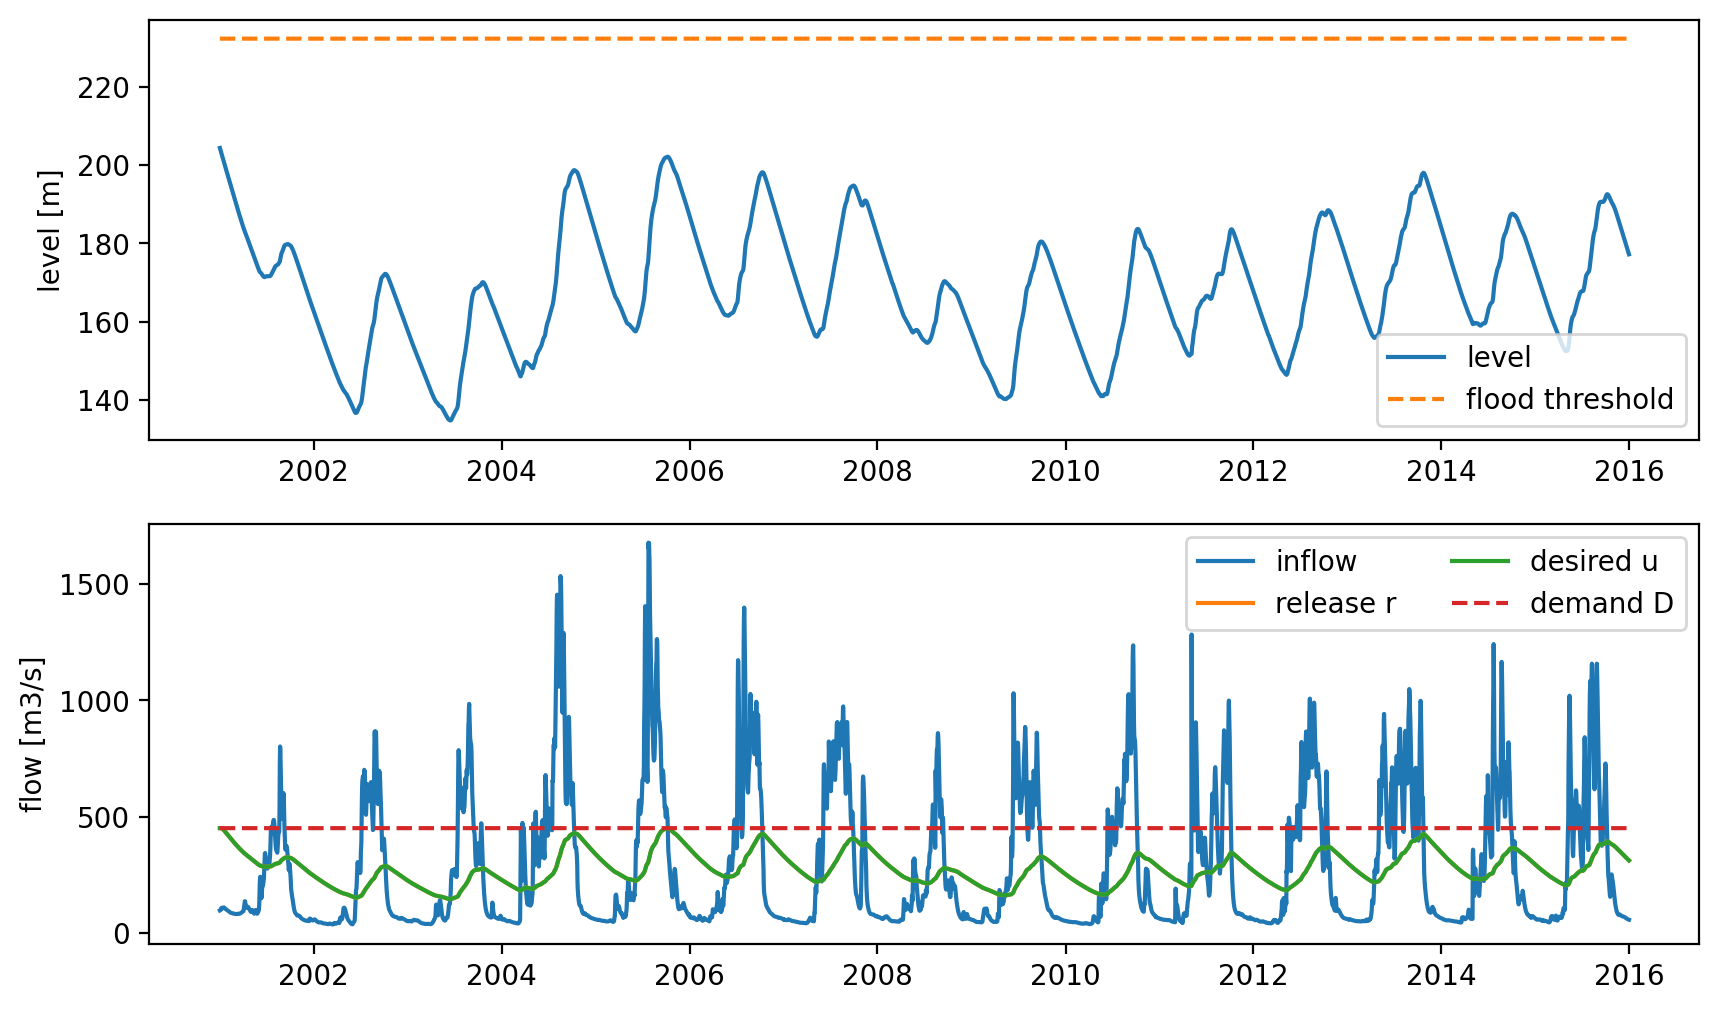

In [5]:
(i1, i2, i3, i4), (s_ts, l_ts, r_ts, u_ts) = simulate_reservoir(
    policy_pwlin, theta0, return_trajectories=True
)

print("Objectives for theta0")
print("flood days/year:", i1)
print("water deficit:", i2)
print("negative hydropower:", i3)
print("level oscillation:", i4)

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(date_range, l_ts)
plt.plot(date_range, l_threshold * np.ones(H), "--")
plt.ylabel("level [m]")
plt.legend(["level", "flood threshold"])

plt.subplot(2, 1, 2)
plt.plot(date_range, inflow , label="inflow")
plt.plot(date_range, r_ts, label="release r")
plt.plot(date_range, u_ts, label="desired u")
plt.plot(date_range, D * np.ones(H), "--", label="demand D")
plt.ylabel("flow [m3/s]")
plt.legend(ncol=2)


## Direct policy search with a multi‑objective EA (NSGA‑II)

DPS treats the policy parameters `θ` as decision variables.
A multi‑objective evolutionary algorithm then searches for parameter vectors that improve tradeoffs across objectives.

We use the `platypus-opt` implementation of NSGA‑II for simplicity.


In [6]:
!pip -q install platypus-opt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 5.0 MB/s eta 0:00:00


In [7]:
from platypus import NSGAII, NSGAIII, Problem, Real

In [8]:
# Pareto filtering (assumes minimization)

def dominates(a, b):
    return (np.all(a <= b) and np.any(a < b))

def pareto_sort(P):
    N = len(P)
    keep = np.ones(N, dtype=bool)
    for i in range(N):
        for j in range(i + 1, N):
            if keep[j] and dominates(P[i, :], P[j, :]):
                keep[j] = False
            elif keep[i] and dominates(P[j, :], P[i, :]):
                keep[i] = False
    return P[keep, :]


Let's optimize for 4 objectives:

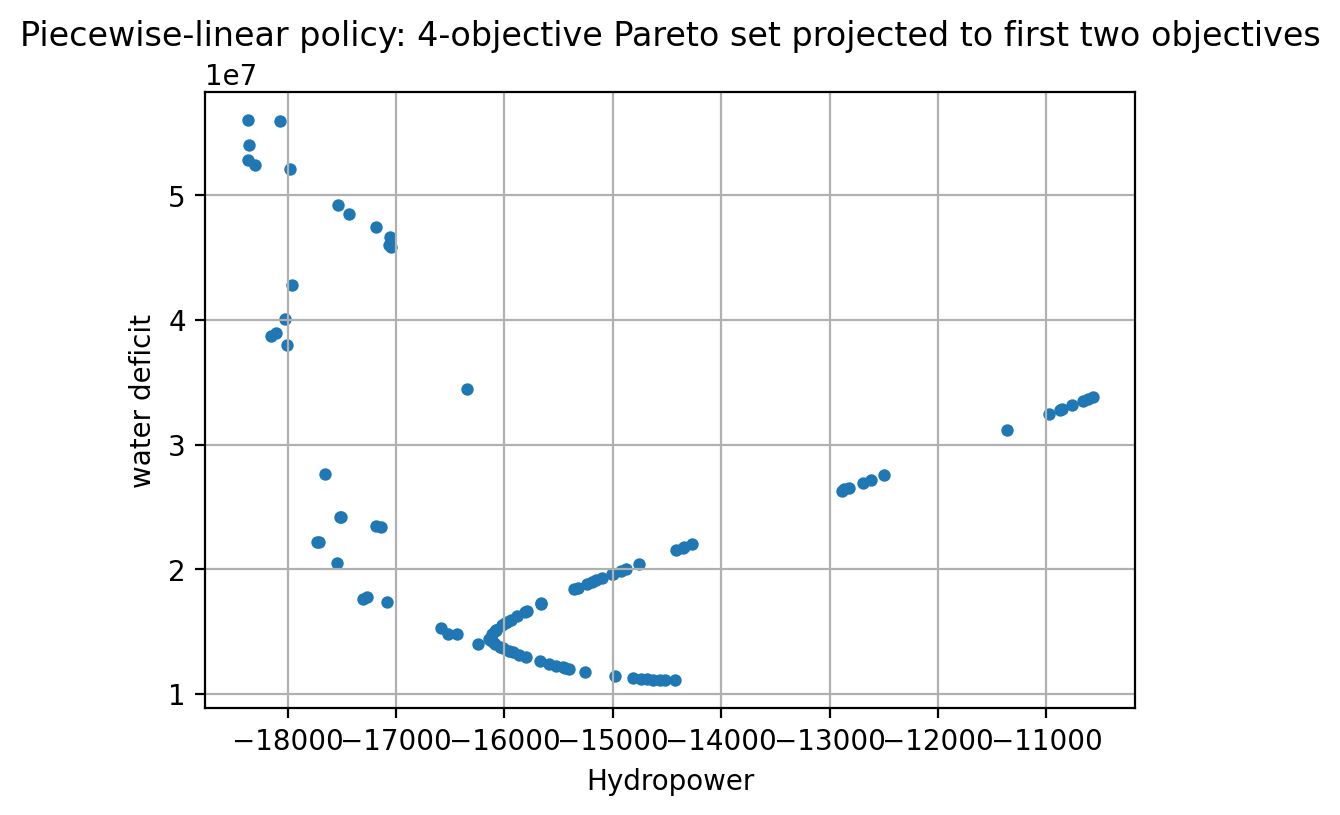

In [9]:
def simulate_pwlin_4obj(theta):
    i1, i2, i3, i4 = simulate_reservoir(policy_pwlin, theta, return_trajectories=False)
    return [i1, i2, i3, i4]

# θ = [θ0, θ1, θ2, θ3]
# - θ0 and θ3 scale with storage, so they are typically small
# - θ1 is a constant target release, optimized (it can be below or above D)
problem4 = Problem(4, 4)

lb_pw = [0.0,  0.0,   -1e10, 0.0]
ub_pw = [0.1,  max_release, 0.0,  0.1]

for k in range(4):
    problem4.types[k] = Real(lb_pw[k], ub_pw[k])

problem4.function = simulate_pwlin_4obj

max_NFE = 1000  # increase for a denser Pareto set
algorithm4 = NSGAII(problem4)
algorithm4.run(max_NFE)

J4 = np.array([s.objectives for s in algorithm4.result])
theta4 = np.array([s.variables for s in algorithm4.result])

plt.figure(figsize=(6, 4))
plt.scatter(J4[:, 2], J4[:, 1], s=12)
plt.xlabel("Hydropower")
plt.ylabel("water deficit")
plt.title("Piecewise-linear policy: 4‑objective Pareto set projected to first two objectives")
plt.grid(True)
plt.show()


### Parallel coordinates view of the 4‑objective Pareto set

Each line is one candidate solution. Values are normalized per objective so the axes share a common scale.
Because all objectives are formulated as minimization, lines closer to the bottom are preferred.


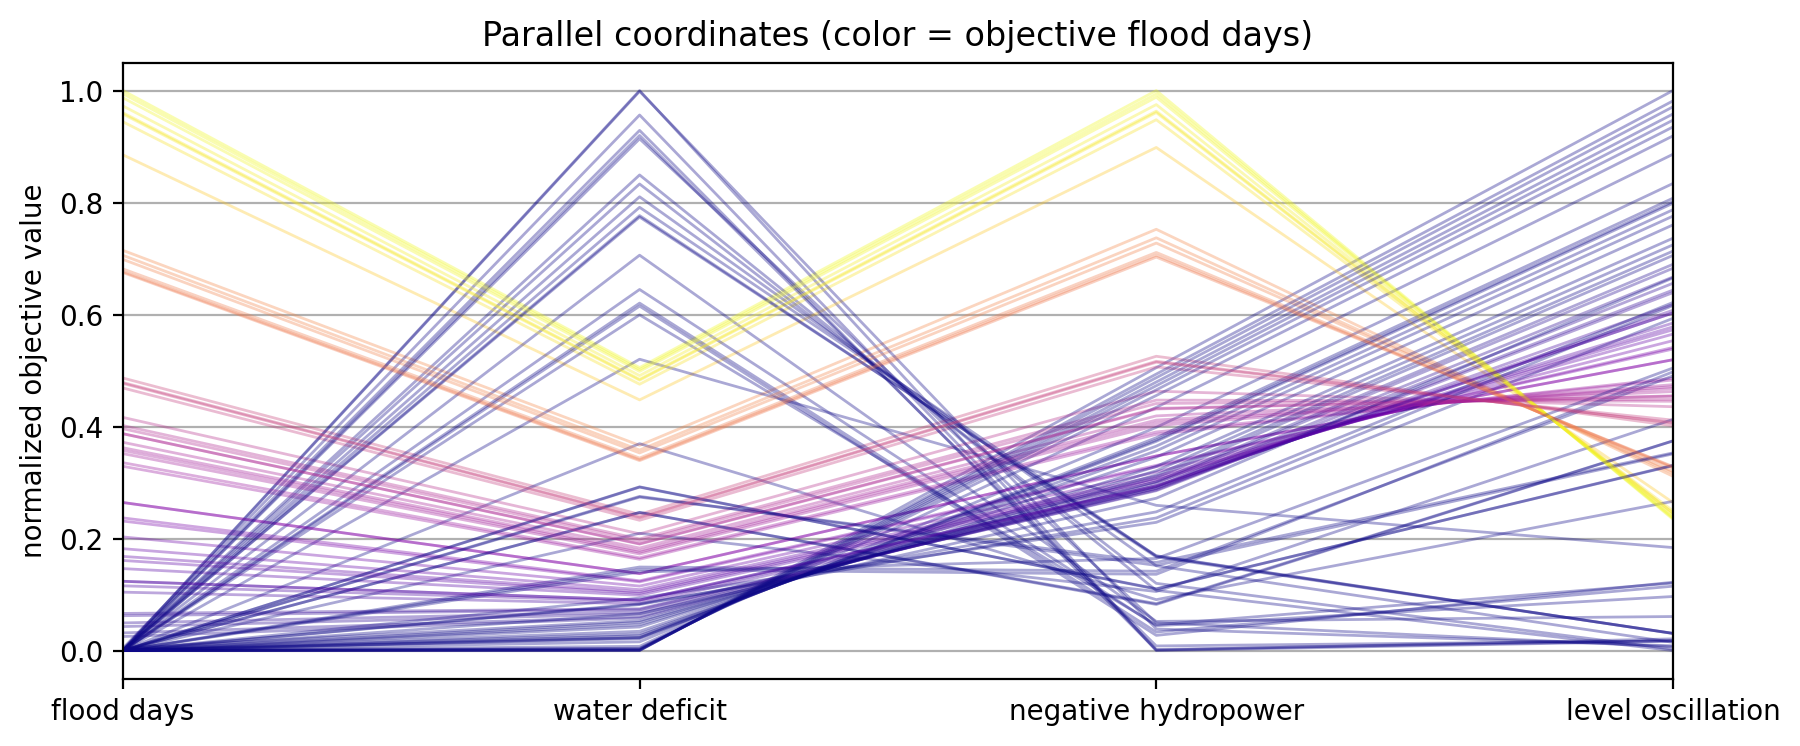

In [10]:
def parallel_coordinates(J, labels, color_by=0, alpha=0.35):
    J = np.asarray(J)
    Jn = (J - J.min(axis=0)) / (J.max(axis=0) - J.min(axis=0) + 1e-12)
    x = np.arange(J.shape[1])

    fig, ax = plt.subplots(figsize=(10, 4))
    norm = plt.Normalize(J[:, color_by].min(), J[:, color_by].max())
    cmap = plt.cm.plasma

    for i in range(J.shape[0]):
        ax.plot(x, Jn[i, :], color=cmap(norm(J[i, color_by])), alpha=alpha, linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlim([0, len(labels) - 1])
    ax.set_ylabel("normalized objective value")
    ax.grid(True, axis="y")
    plt.title("Parallel coordinates (color = objective {})".format(labels[color_by]))
    plt.show()

parallel_coordinates(
    J4,
    labels=["flood days", "water deficit", "negative hydropower", "level oscillation"],
    color_by=0
)


## RBF policy class (3 internal nodes)

The piecewise linear policy is easy to interpret, but it restricts the mapping from storage to release.
A common alternative in DPS is to use a smooth basis expansion such as an RBF network.

Here we implement an RBF policy consistent with the provided MATLAB function `rbf.m`:
- Input: normalized storage `x = s/S` in `[0, 1]`
- Output: normalized desired release `y` in `[0, 1]`, then `u = y * max_release`

We use **3 internal nodes** (3 Gaussian basis functions).


In [11]:
# ======================================================================
# THIS DEFINES THE RBF AND ITS PARAMETERS. REUSE THIS PIECE OF CODE ANYTIME
# YOU WANT TO USE RBF OPTIMIZATION
# ======================================================================

def _expected_rbf_param_len(n_in: int, n_basis: int, n_out: int) -> int:
    """
    Your intended formulation:
      const: (n_out,)
      centers: (n_basis, n_in)
      radii:   (n_basis, n_in)        # always "diag" widths
      weights: (n_out, n_basis)       # full weight matrix

    Total length = n_out + n_basis*(2*n_in + n_out)
                 = n_basis*(2*n_in + n_out) + n_out
    """
    return int(n_out + n_basis * (2 * n_in + n_out))


def _unpack_rbf_params(param, n_in, n_basis, n_out):
    """
    Flat parameter vector layout (matches length n_basis*(2*n_in + n_out) + n_out):

      bias (const): (n_out,)
      centers C:    (n_basis, n_in)
      radii   B:    (n_basis, n_in)         # diagonal widths per basis per input
      weights W:    (n_out, n_basis)        # one weight per (output, basis)

    Notes:
    - This is the "full" formulation (each output has its own weights for each basis).
    - Parameter length is validated strictly and raises a clear error if mismatched.
    """
    p = np.asarray(param, dtype=float).reshape(-1)

    expected = _expected_rbf_param_len(n_in, n_basis, n_out)
    if p.size != expected:
        raise ValueError(
            f"param has length {p.size}, but expected {expected} for "
            f"n_in={n_in}, n_basis={n_basis}, n_out={n_out} "
            f"(expected = n_basis*(2*n_in + n_out) + n_out)."
        )

    i = 0
    bias = p[i:i + n_out]; i += n_out
    C = p[i:i + n_basis * n_in].reshape(n_basis, n_in); i += n_basis * n_in
    B = p[i:i + n_basis * n_in].reshape(n_basis, n_in); i += n_basis * n_in
    W = p[i:i + n_out * n_basis].reshape(n_out, n_basis); i += n_out * n_basis

    # i should equal p.size by construction; keep as a guard.
    if i != p.size:
        raise ValueError(f"Internal parsing error: consumed {i} params out of {p.size}.")

    return bias, C, B, W


def rbf_policy(x, param, n_in, n_basis, n_out=1,
               y_low=0.0, y_high=1.0,
               squash="clip"):
    """
    Generic RBF policy with:
      - n_in inputs
      - n_basis Gaussian basis functions
      - n_out outputs

    Formulation (your requested one):
      phi_i(x) = exp( - sum_j ((x_j - C_ij)^2 / B_ij^2) )    for i=1..n_basis
      z_k      = bias_k + sum_i W_{k,i} * phi_i             for k=1..n_out

    Output mapping:
      squash="sigmoid": y01 = sigmoid(z)   (smooth, always in (0,1))
      squash="clip":    y01 = clip(z,0,1)  (hard clip, better for low release)

    Scaling:
      y = y_low + y01*(y_high - y_low)

    Returns:
      scalar if n_out==1 else (n_out,) ndarray.
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    if x.size != n_in:
        raise ValueError(f"x has length {x.size}, expected n_in={n_in}.")

    bias, C, B, W = _unpack_rbf_params(param, n_in, n_basis, n_out)

    # Safe radii to avoid division by zero
    eps = 1e-6
    B_safe = np.maximum(np.abs(B), eps)                      # (n_basis, n_in)
    d2 = np.sum(((x[None, :] - C) / B_safe) ** 2, axis=1)    # (n_basis,)
    phi = np.exp(-d2)                                        # (n_basis,)

    z = bias + (W @ phi)                                     # (n_out,)

    if squash == "sigmoid":
        y01 = 1.0 / (1.0 + np.exp(-z))
    elif squash == "clip":
        y01 = np.clip(z, 0.0, 1.0)
    else:
        raise ValueError("squash must be 'sigmoid' or 'clip'")

    # scale to [y_low, y_high]
    y_low = np.asarray(y_low, dtype=float)
    y_high = np.asarray(y_high, dtype=float)

    if y_low.ndim == 0:
        y_low = np.full(n_out, float(y_low))
    if y_high.ndim == 0:
        y_high = np.full(n_out, float(y_high))

    if y_low.size != n_out or y_high.size != n_out:
        raise ValueError("y_low and y_high must be scalars or length n_out arrays.")

    y = y_low + y01 * (y_high - y_low)

    return float(y[0]) if n_out == 1 else y


# THIS IS HOW YOU USE IT


```
y = rbf_policy(x, parameters, n_in=1, n_basis=3, n_out=1)
u = y*max_release
```

where:
  

*   `x` is the normalized input:`x = s / S_max`
*   `n_in`: is the number of inputs (here, just storage, but you could potentially add time, forecasts, observations...)
*   `n_out`: is the number of outputs (here, just reservoir release)
*   `n_basis`: is the number of hidden nodes. A good rule of thumb is setting `n_basis = n_in + n_out + 1`
*   `parameters`: is a vector of parameters whose length depends on the above properties.

`Number of parameters = n_basis*(2*n_in + n_out) + n_out`
*   `y` is the outputs, which is normalized in [0,1]. You can obtain u by multiplying it by max release.


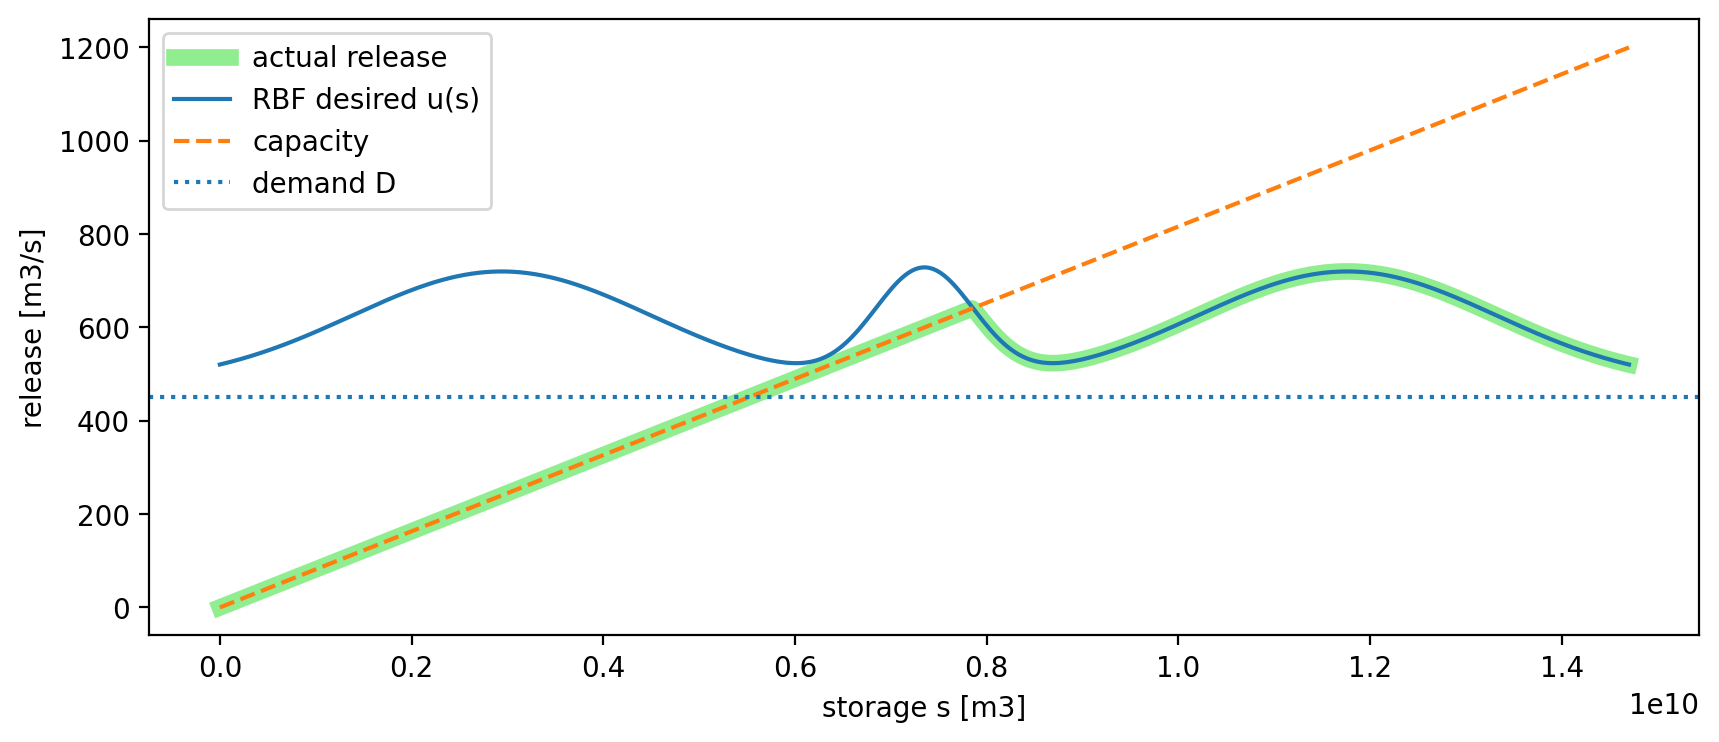

In [12]:
# visualize one random RBF policy

n_in=1
n_basis=3
n_out=1

n_param = n_basis*(2*n_in + n_out) + n_out

param0 = np.array([
    0.4,          # bias
    0.2, 0.5, 0.8,# centers c1,c2,c3
    0.15,0.05,0.15,# widths b1,b2,b3
    0.2, 0.2, 0.2 # weights w1,w2,w3
], dtype=float)


u_rbf = max_release * np.array([rbf_policy([s/S], param0, n_in=1, n_basis=3, n_out=1) for s in s_values])
actual_release = np.minimum(u_rbf, cap_values)

plt.figure()
plt.plot(s_values,actual_release,linestyle="-",color="lightgreen",linewidth=6,label="actual release")
plt.plot(s_values, u_rbf, label="RBF desired u(s)")
plt.plot(s_values, cap_values, "--", label="capacity")
plt.axhline(D, linestyle=":", label="demand D")
plt.xlabel("storage s [m3]")
plt.ylabel("release [m3/s]")
plt.legend()
plt.show()


## Solve the 4‑objective problem with the RBF policy


Now, we have to wrap the generic function `rbf_policy` into a custom function for our problem, where inputs, n_in, n_out, n_basis are defined internally.
(In the HW, this needs to be adapted to your problem.)

In [13]:
def rbf_policy_gibe(s, theta):
    # storage-only RBF input
    s_norm = float(s) / float(S)
    x = np.array([s_norm], dtype=float)   # shape (1,)

    return max_release* float(
        rbf_policy(
            x, theta,
            n_in=1,
            n_basis=n_basis,
            n_out=n_out,
        )
    )

Now we can use MOEAs to find the optimal parameter set for our custom RBF function

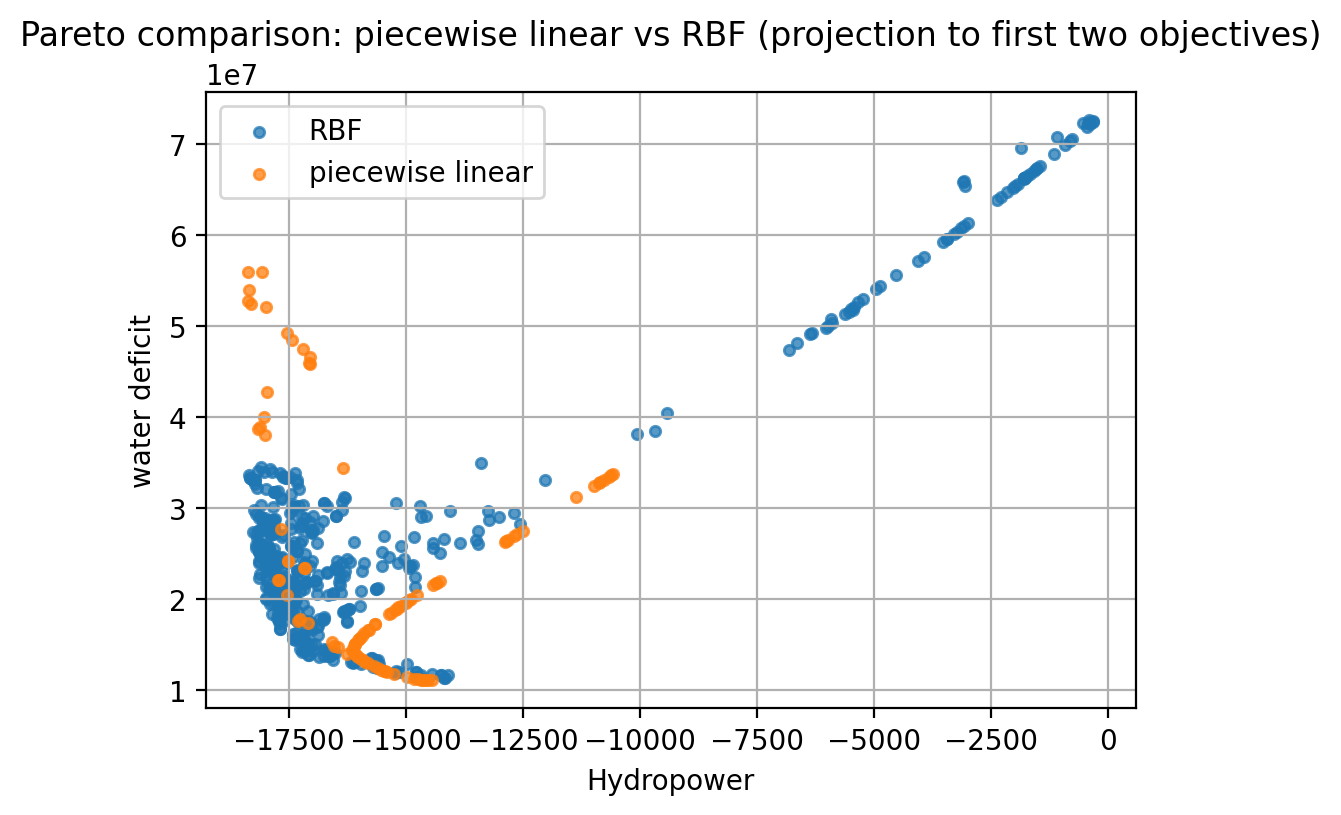

In [15]:
def simulate_rbf_4obj(param):
    i1, i2, i3, i4 = simulate_reservoir(rbf_policy_gibe, param, return_trajectories=False)
    return [i1, i2, i3, i4]

problem_rbf = Problem(n_param, 4)

# Bounds:
# Reuse this code any time you need to define lower and upper bounds of RBF parameters
# [bias | centers (all) | widths (all) | weights (all)]

lb_bias    = -1.0 * np.ones(n_out)
ub_bias    =  1.0 * np.ones(n_out)

lb_centers =  0.0 * np.ones(n_basis * n_in)
ub_centers =  1.0 * np.ones(n_basis * n_in)

lb_widths  =  0.0 * np.ones(n_basis * n_in)
ub_widths  =  1.0  * np.ones(n_basis * n_in)

lb_weights = -1.0 * np.ones(n_out * n_basis)
ub_weights =  1.0 * np.ones(n_out * n_basis)

LB = np.concatenate([lb_bias, lb_centers, lb_widths, lb_weights])
UB = np.concatenate([ub_bias, ub_centers, ub_widths, ub_weights])

problem_rbf = Problem(n_param, 4)
for k in range(n_param):
    problem_rbf.types[k] = Real(float(LB[k]), float(UB[k]))

problem_rbf.function = simulate_rbf_4obj
problem_rbf.types[:] = [Real(LB[j], UB[j]) for j in range(n_param)]


# This problem has a larger number of parameters than the PWL, so we'll give it more NFE
max_NFE = 2000 ###5,000 NFE takes 30+ minutes to run
algorithm_rbf = NSGAIII(problem_rbf, divisions_outer = 12) # NSGA3 better for many objs problems (>3objs). division outer represents number of reference points
algorithm_rbf.run(max_NFE)

J_rbf = np.array([s.objectives for s in algorithm_rbf.result])
param_rbf = np.array([s.variables for s in algorithm_rbf.result])

# Compare the two Pareto sets in the same projection
plt.figure(figsize=(6, 4))
plt.scatter(J_rbf[:, 2], J_rbf[:, 1], s=14, alpha=0.75, label="RBF")
plt.scatter(J4[:, 2], J4[:, 1], s=14, alpha=0.75, label="piecewise linear")
plt.xlabel("Hydropower")
plt.ylabel("water deficit")
plt.title("Pareto comparison: piecewise linear vs RBF (projection to first two objectives)")
plt.grid(True)
plt.legend()
plt.show()





## Compare a sample piecewise‑linear and RBF solution

To compare policies directly, pick one candidate from each Pareto set and plot the resulting trajectories.


In [ ]:
# Pick the solution with smallest sum of normalized objectives (simple compromise heuristic)
def pick_policy(J):
    J = np.asarray(J)
    return int(np.argmin(J[:, 2]))  # for example, let's pick the best HP policy to compare

idx_pw = pick_policy(J4)
idx_rbf = pick_policy(J_rbf)

theta_star = theta4[idx_pw]
param_star = param_rbf[idx_rbf]

(obj_pw, traj_pw) = simulate_reservoir(policy_pwlin, theta_star, return_trajectories=True)
(obj_rbf, traj_rbf) = simulate_reservoir(rbf_policy_gibe, param_star, return_trajectories=True)

print("Piecewise-linear compromise objectives:", obj_pw)
print("RBF compromise objectives:", obj_rbf)

s_pw, l_pw, r_pw, u_pw = traj_pw
s_rb, l_rb, r_rb, u_rb = traj_rbf

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(date_range, l_pw, label="level (pwlin)")
plt.plot(date_range, l_rb, label="level (RBF)", alpha=0.8)
plt.plot(date_range, l_threshold * np.ones(H), "--", label="flood threshold")
plt.ylabel("level [m]")
plt.legend(ncol=3)

plt.subplot(2, 1, 2)
plt.plot(date_range, r_pw, label="release r (pwlin)")
plt.plot(date_range, r_rb, label="release r (RBF)", alpha=0.8)
plt.axhline(D, linestyle="--", label="demand")
plt.ylabel("release [m3/s]")
plt.xlabel("date")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()


# Visualize the policy shape over storage
s_values = np.linspace(0, S, 400)
u_pwlin = np.array([policy_pwlin(s, theta_star) for s in s_values])
u_rbf = np.array([rbf_policy_gibe(s, param_star) for s in s_values])

actual_release_pwlin = np.minimum(u_pwlin, cap_values)
actual_release_rbf = np.minimum(u_rbf, cap_values)

plt.figure()
plt.plot(s_values,actual_release_pwlin,linestyle="-",color="lightblue",linewidth=6,label="actual release PWLIN")
plt.plot(s_values, u_pwlin, color="blue", label="desired u(s) pwlin")
plt.plot(s_values,actual_release_rbf,linestyle="-",color="orange",linewidth=6,label="actual release RBF")
plt.plot(s_values, u_rbf, color="red", label="desired u(s) RBF")

plt.plot(s_values, cap_values, "--", label="capacity s * max_release/S")
plt.axhline(D, linestyle=":", label="demand D")




plt.xlabel("storage s [m3]")
plt.ylabel("release [m3/s]")
plt.ylim([0, 1500])
plt.legend()
plt.show()
